In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor

In [2]:
data = pd.read_csv('hotel_booking.csv')

## Data exploration and preparation

### Data Selection

In [3]:
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,Transient,96.14,0,0,Check-Out,2017-09-06,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,Transient,225.43,0,2,Check-Out,2017-09-07,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,Transient,157.71,0,4,Check-Out,2017-09-07,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,Transient,104.40,0,0,Check-Out,2017-09-07,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


Some columns have personal information that may not be useful for the analysis, such as the name of the person who made the reservation, the email, the phone number and the credit card number. This information does not provide any insights for predicting the cancellations, so we can drop these columns.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

The dataset has 119390 rows and 36 columns.
With the info method we can see that there are some missing values in the columns children, country and agent and company.
We have 16 columns with type object, 16 columns with type int64 and 4 columns with type float64.

In [5]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


This method provides statistics for the numerical columns, revealing that the values vary widely, with the smallest being -6.38 and the largest 5400. Such differences in ranges could impact model performance, suggesting the need for data normalization.
Since there isn’t a large gap between the mean and median, we can assume the data is not significantly skewed.
We will check these assumptions later with the help of visualizations.

In [6]:
data.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,name,email,phone-number,credit_card
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926,81503,115889,119390,9000
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21,Michael Johnson,Michael.C@gmail.com,669-792-1661,************4923
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461,48,6,1,28


In [7]:
data['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

For the object columns, we can see that the dataset has a range of unique values, from 2 to 119390. Columns with a high number of unique values or low frequency of the top value may not be useful for the analysis, so we can drop them. This reinforces the idea of dropping the columns with personal information.

eliminar 'reservation_status', uma vez que queremos prever se o booking foi cancelado ou não, e não teriamos acesso a esta infromação
eliminar 'reservation_status_date', uma vez que nos dá informação sobre quando o cliente fez check-out, ou se nao apareceu o dia em que divia aparecer.


In [8]:
data.drop(columns=['name','email','phone-number','credit_card', 'reservation_status', 'reservation_status_date'], axis = 1, inplace=True)

##### Univariate Analysis

In [9]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

In [10]:
def boxplot_visualization(data, columns, title):
    n_cols = min(5, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(data=data, y=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_ylabel("")

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()
    
def barplot_visualization(data, columns, title):
    n_cols = min(5, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        label = data.groupby(col).size()
        sns.barplot(x=label.index, y=label.values, ax=axes[i])
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].tick_params(axis="x", rotation=45)

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()

In [11]:
numerical_columns_box = ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 
 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 
 'agent', 'adr', 'total_of_special_requests']

numerical_columns_barplot = ['adults', 'children', 'babies', 'is_repeated_guest', 
 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces']

categorical_columns_barplot = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 
 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 
 'deposit_type', 'customer_type']

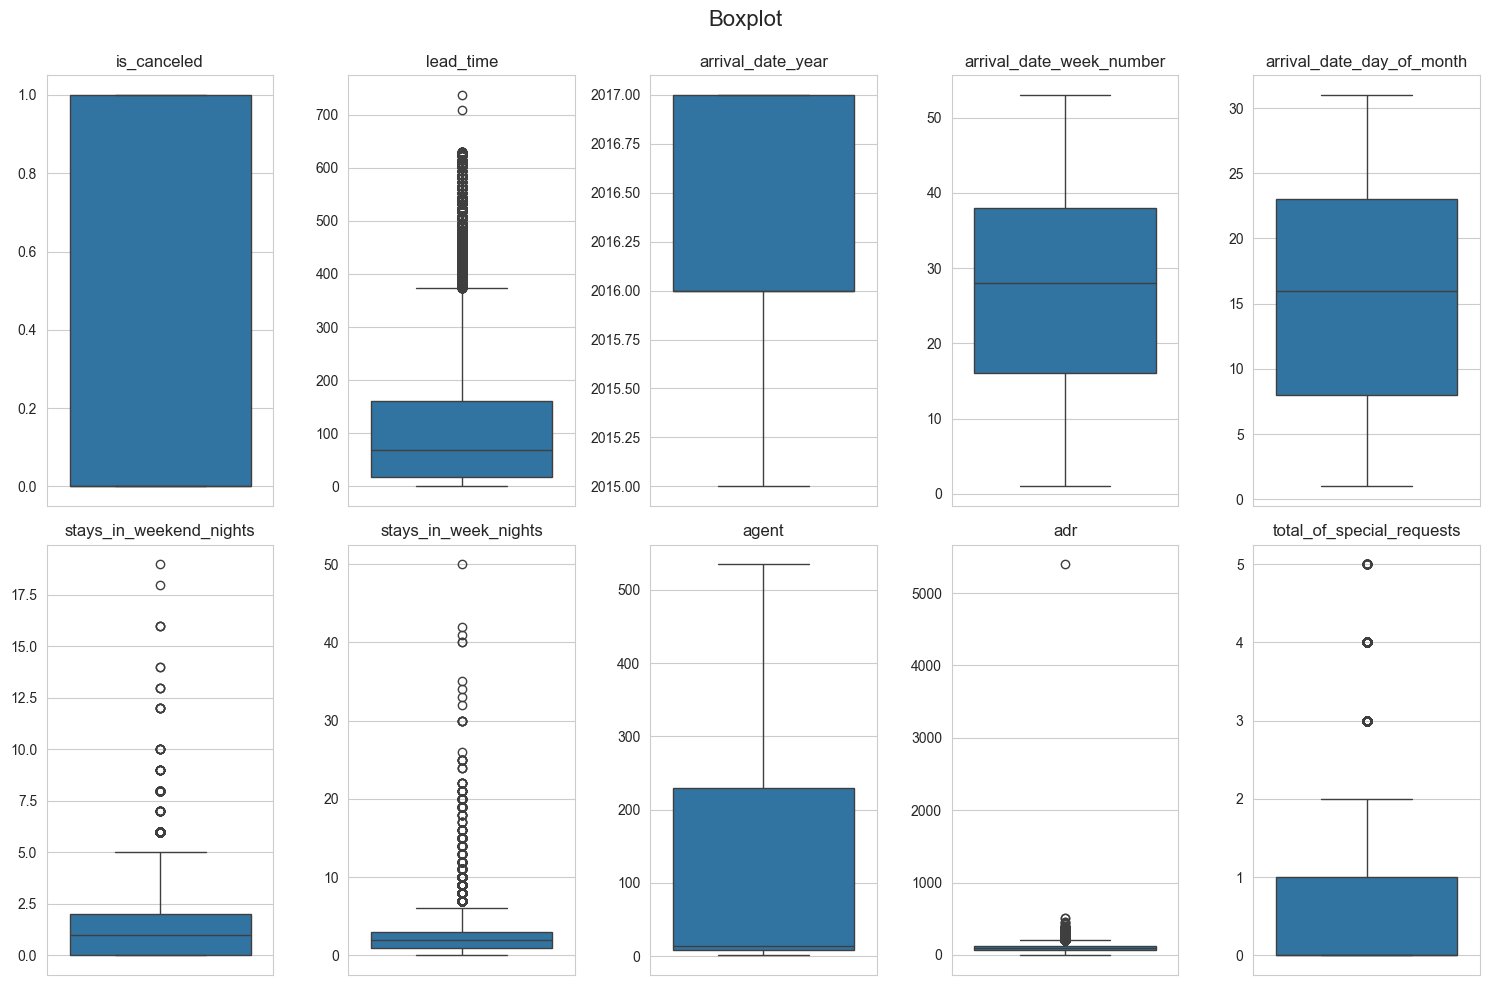

In [12]:
boxplot_visualization(data, numerical_columns_box,"Boxplot")

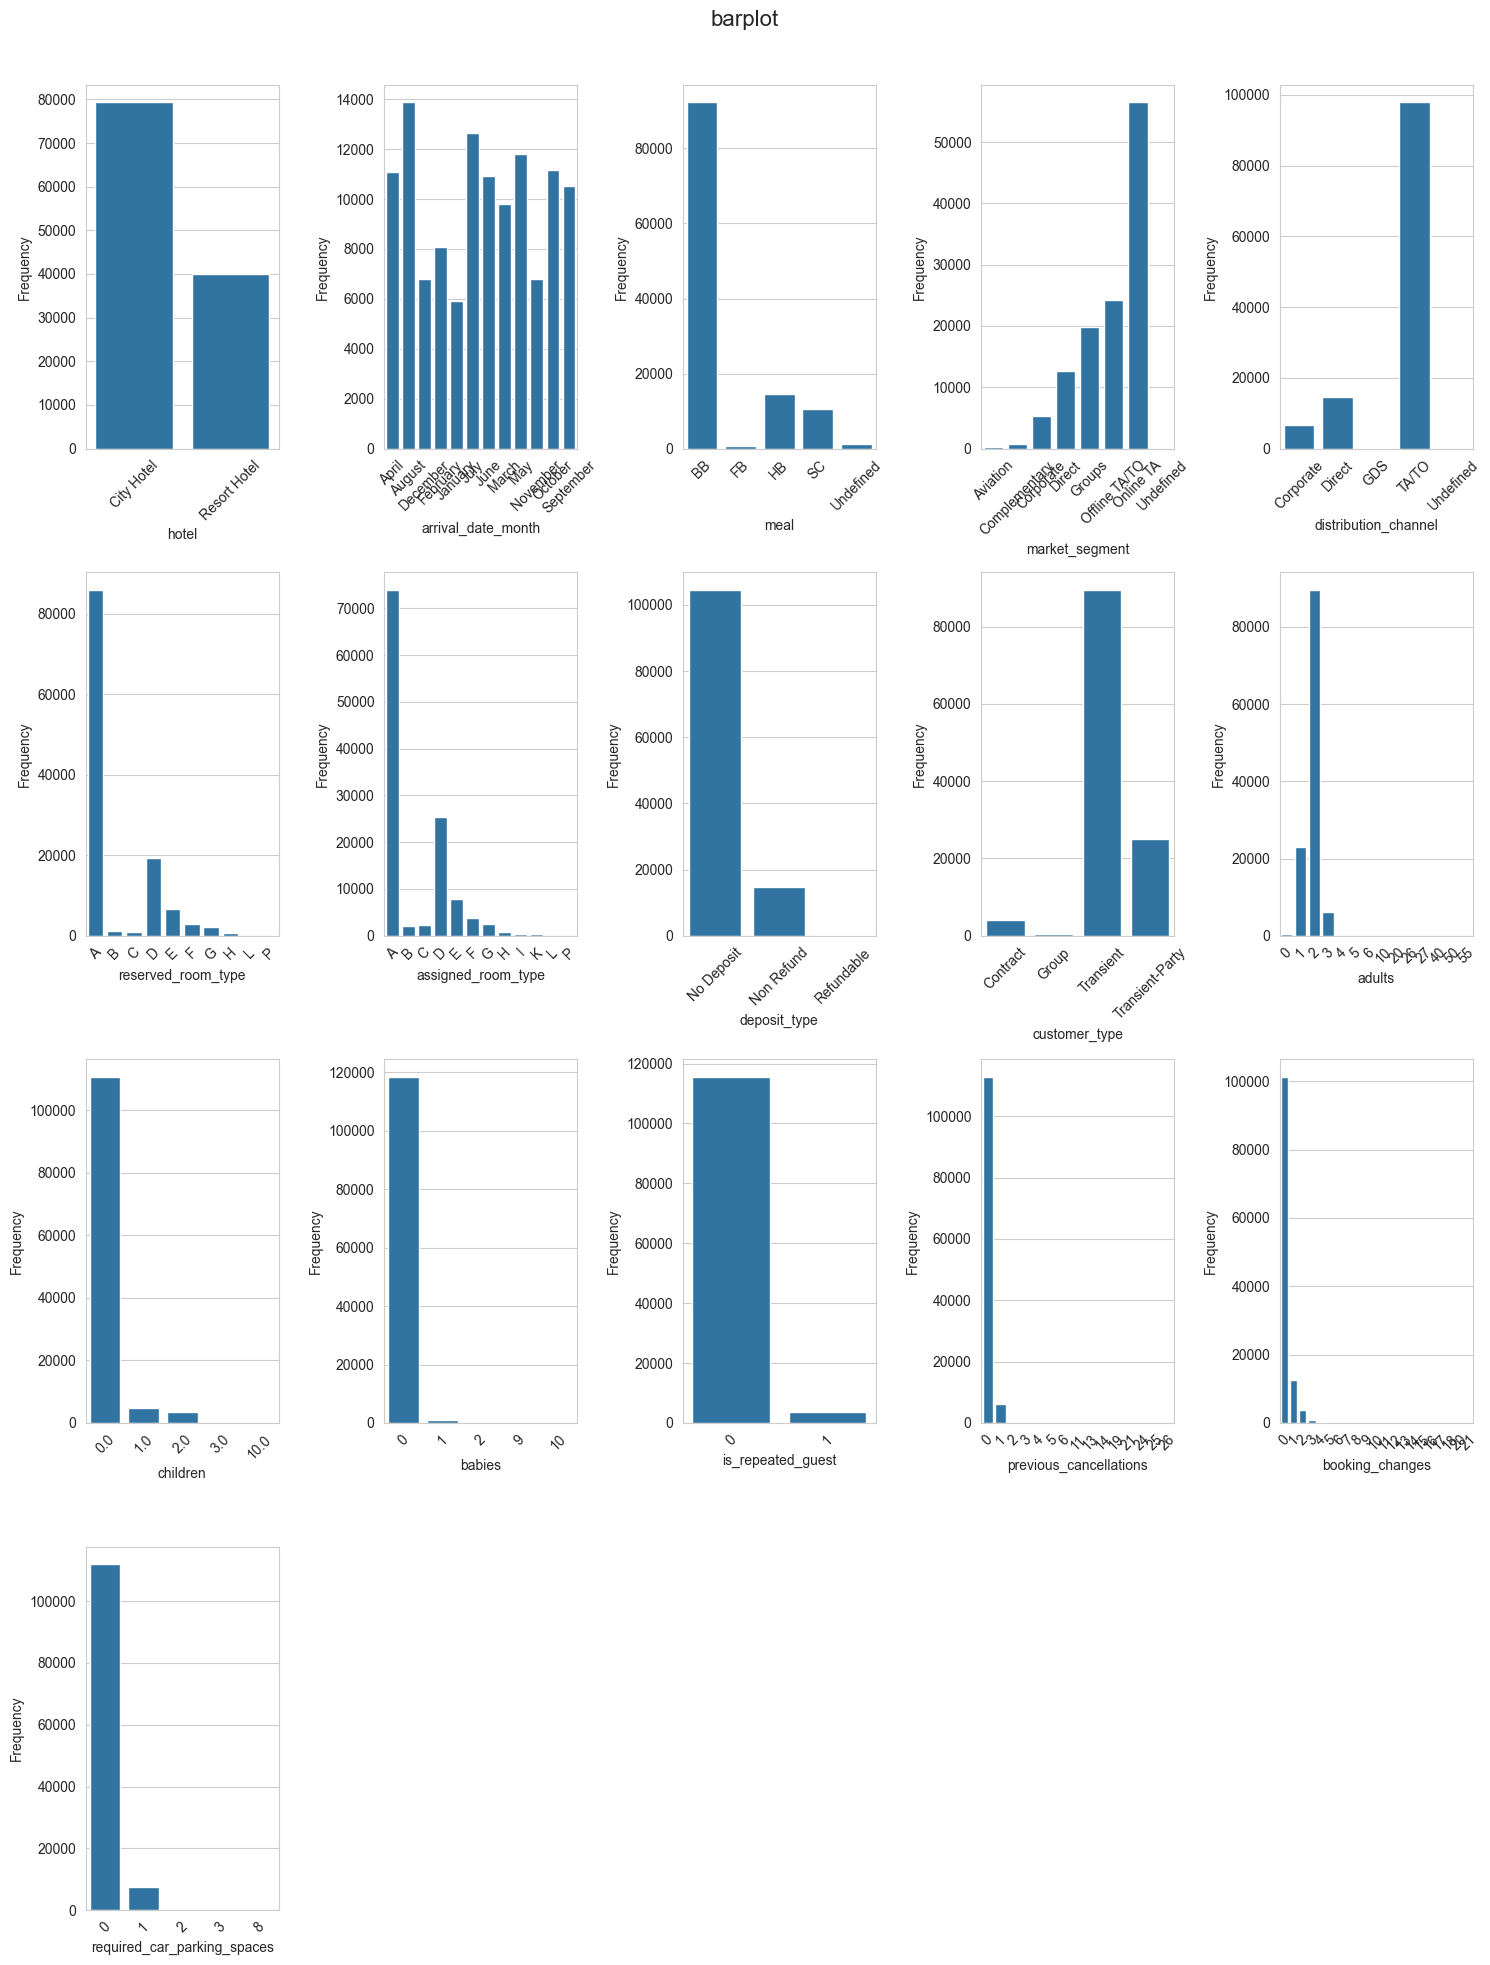

In [13]:
barplot_visualization(data, categorical_columns_barplot + numerical_columns_barplot,"barplot")

##### Bivariate Analysis

In [14]:
def boxplot_by_type_visualization(data, columns, title):
    columns = [col for col in columns if col != 'is_canceled']
    n_cols = min(4, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(x='is_canceled', y=col, data=data, ax=axes[i])
        axes[i].set_xlabel('is_canceled')
        axes[i].set_ylabel(col)

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()

def crosstab_by_type_visualization(data, columns, title):
    n_cols = min(4, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        crosstab_result = pd.crosstab(data[col], data['is_canceled'])
        crosstab_result.plot(kind="bar", ax=axes[i])
        axes[i].set_xlabel('is_canceled')
        axes[i].set_ylabel(col)
        axes[i].tick_params(axis="x", rotation=45)

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()

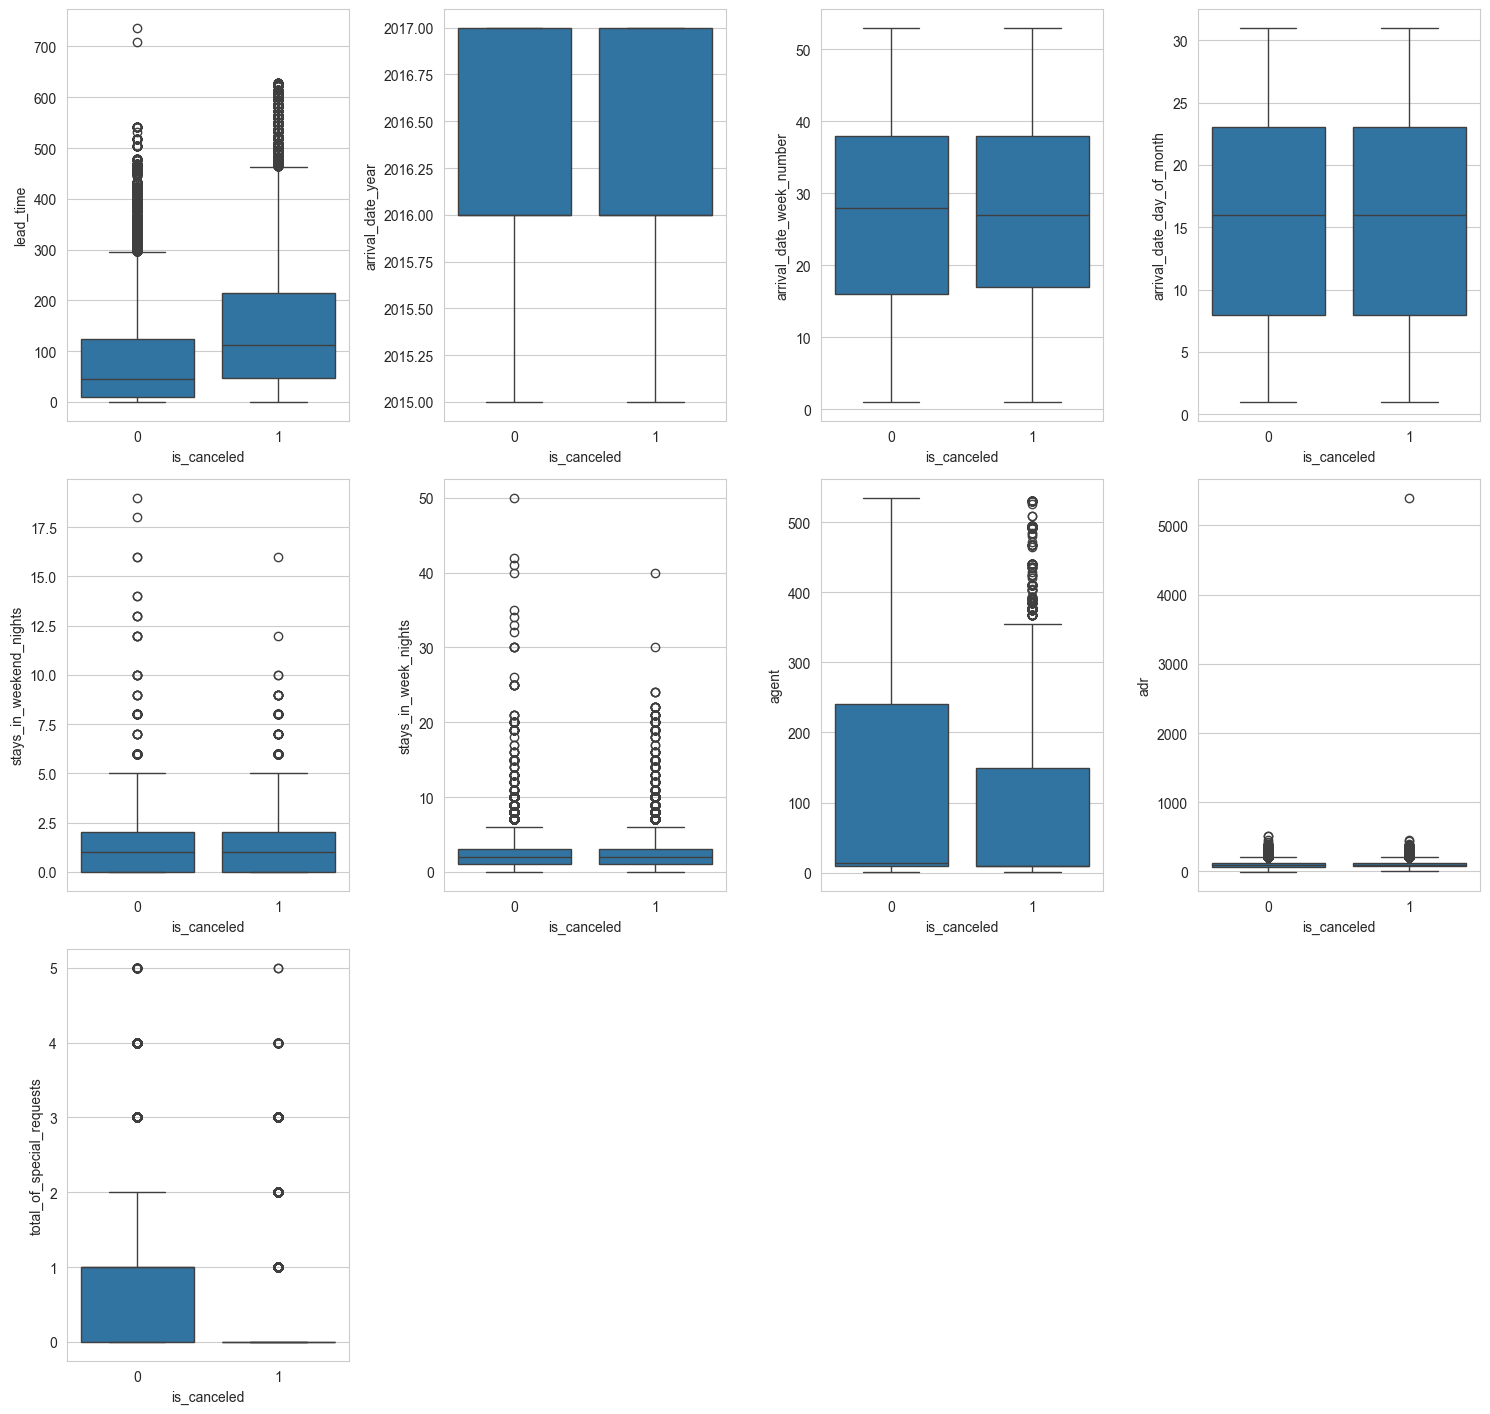

In [15]:
boxplot_by_type_visualization(data, numerical_columns_box,'')

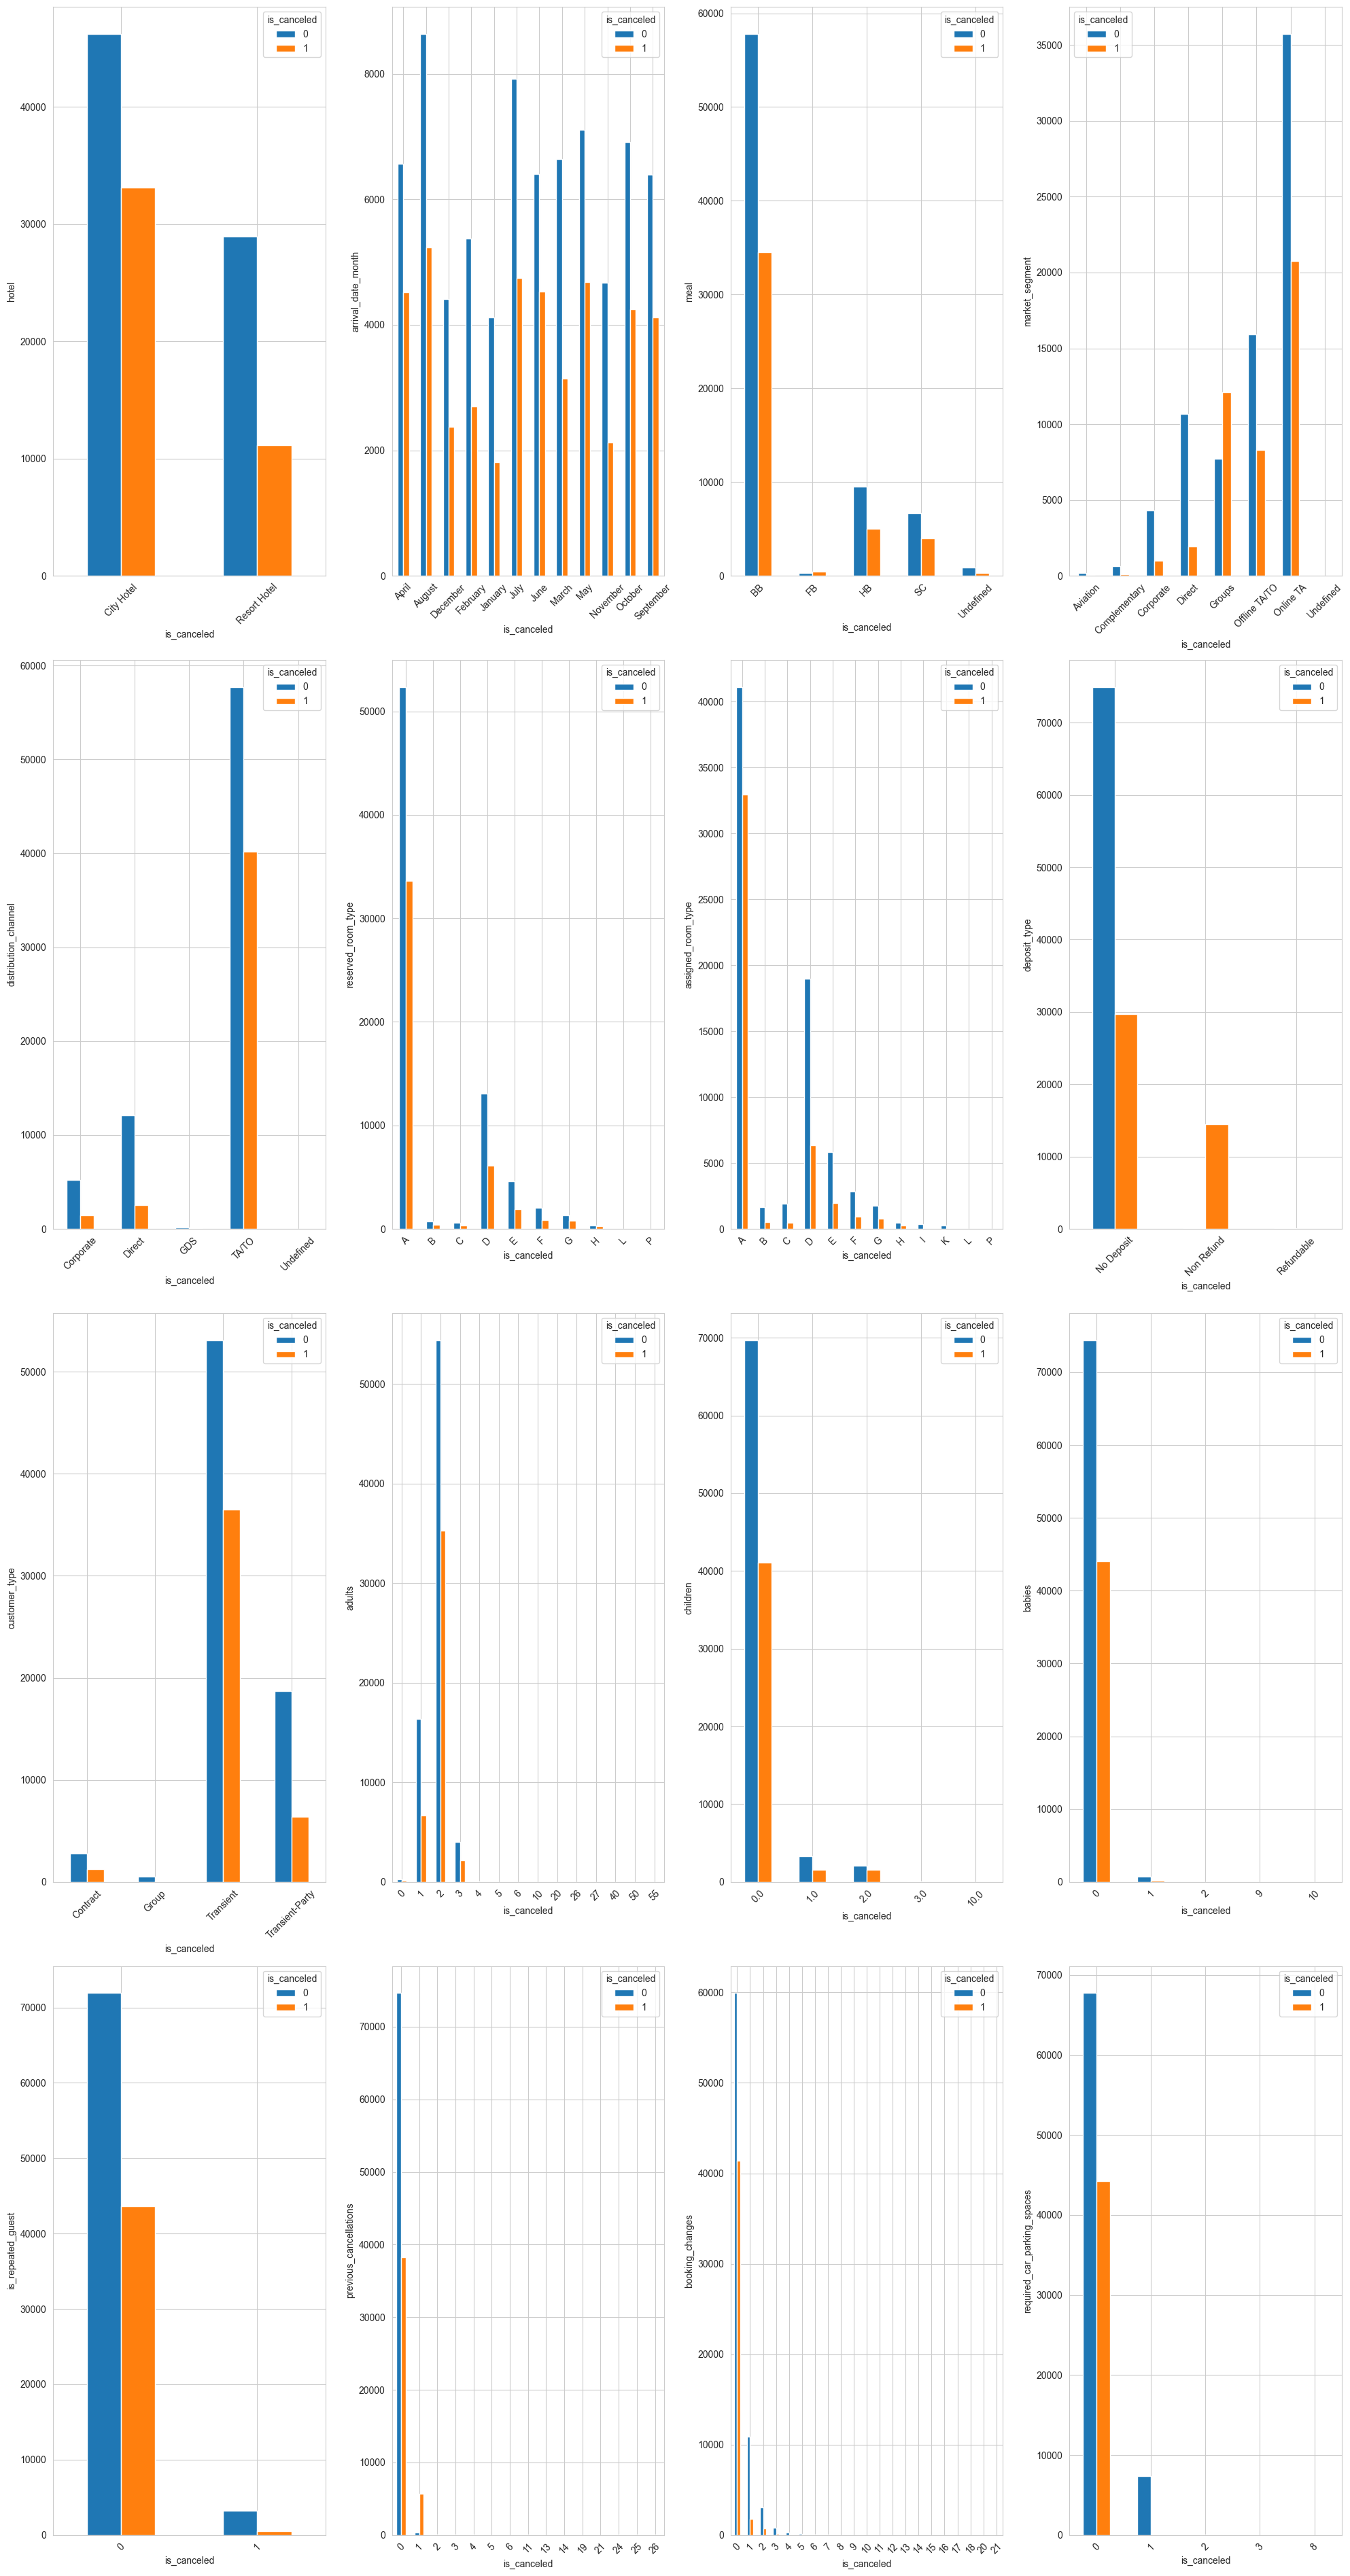

In [16]:
crosstab_by_type_visualization(data, categorical_columns_barplot + numerical_columns_barplot,'')

### Data Cleaning

##### Dealing with missing values

In [17]:
data.isnull().sum()[data.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [18]:
data.isnull().sum()[data.isnull().sum() > 0]/len(data)

children    0.000034
country     0.004087
agent       0.136862
company     0.943069
dtype: float64

Given the large number of missing values (94.3%) in the company column, we can drop it.
The children and agent columns have a small number of missing values so we can fill them with 0, assuming that the missing values are due to the absence of children or agents.
The country column has a small number of missing values, so we can fill them with the most frequent value.


In [19]:
data.drop(columns=['company'], axis = 1, inplace=True)
data[['children','agent']] = data[['children','agent']].fillna(0)
data['country'] = data['country'].fillna(data['country'].mode().iloc[0])

##### Resolve inconsistencies
Drop the rows that have a total of 0 nights booked and 0 guests and the duplicate rows.

In [20]:
data = data[data['stays_in_weekend_nights'] + data['stays_in_week_nights'] > 0]
data = data[(data['adults'] + data['children'] + data['babies']) > 0]
data = data.drop_duplicates()

##### Remove Outliers

eu nos decidimos usar o lof, para detetar outliers, 
para conseguirmos usar o lof, os dados precisoam de estar encoder, logo vamos usar o labelEncoder para isso

In [21]:
label_encoder = LabelEncoder()
encoded_data = data.copy()
for col in data.columns: 
    encoded_data[col] = label_encoder.fit_transform(data[col])

In [22]:
lof = LocalOutlierFactor(contamination=0.1)
outliers = lof.fit_predict(encoded_data)
encoded_data["LOF"] = outliers

Valores marcados com -1 são outliers, logo vamos retira-los, e dropar a coluna 'LOF'

In [23]:
encoded_data = encoded_data[encoded_data["LOF"] == 1]  
encoded_data = encoded_data.drop(columns=['LOF'], axis=1)

### Data Reduction

In [24]:
corr_matrix = encoded_data.corr(numeric_only=True)

In [25]:
## kn . nb e  ensemble, redes n 

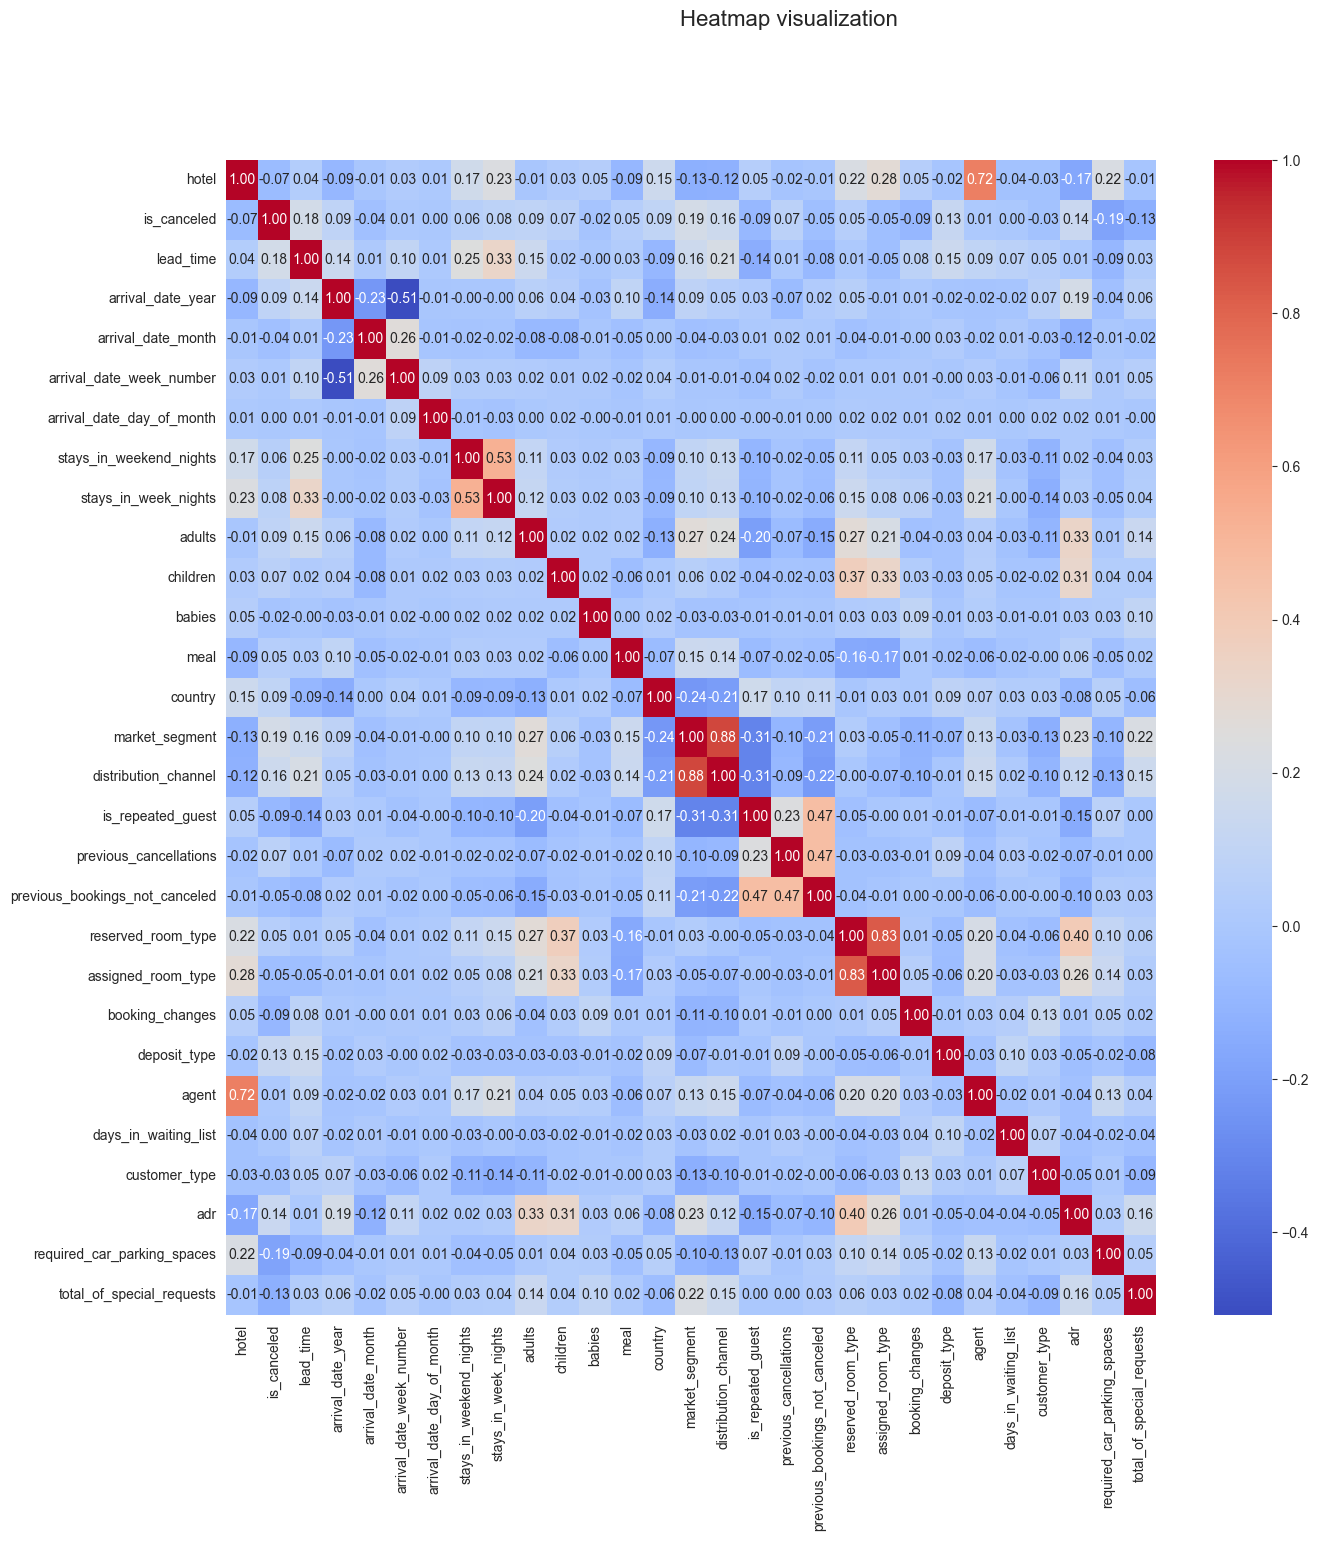

In [26]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.suptitle('Heatmap visualization', fontsize=16)
plt.show()

como a correlação está baixa vamos tentar criar features.

In [27]:
encoded_data['room_type_match'] = (encoded_data['reserved_room_type'] == encoded_data['assigned_room_type']).astype(int)

In [31]:
encoded_data['num_people'] = encoded_data['adults'] + encoded_data['children'] + encoded_data['babies']

def lead_time_category(lead_time):
    if lead_time <= 7:
        return 0
    elif 7 < lead_time <= 30:
        return 1
    else:
        return 2
encoded_data['lead_time_category'] = encoded_data['lead_time'].apply(lead_time_category)

data.groupby('arrival_date_week_number').size()
encoded_data['epoca'] = encoded_data['arrival_date_month'].apply(epoca_do_ano)

In [32]:
encoded_data = encoded_data.drop(columns=['reserved_room_type','assigned_room_type', 'adults', 'children', 'babies', 'lead_time'])

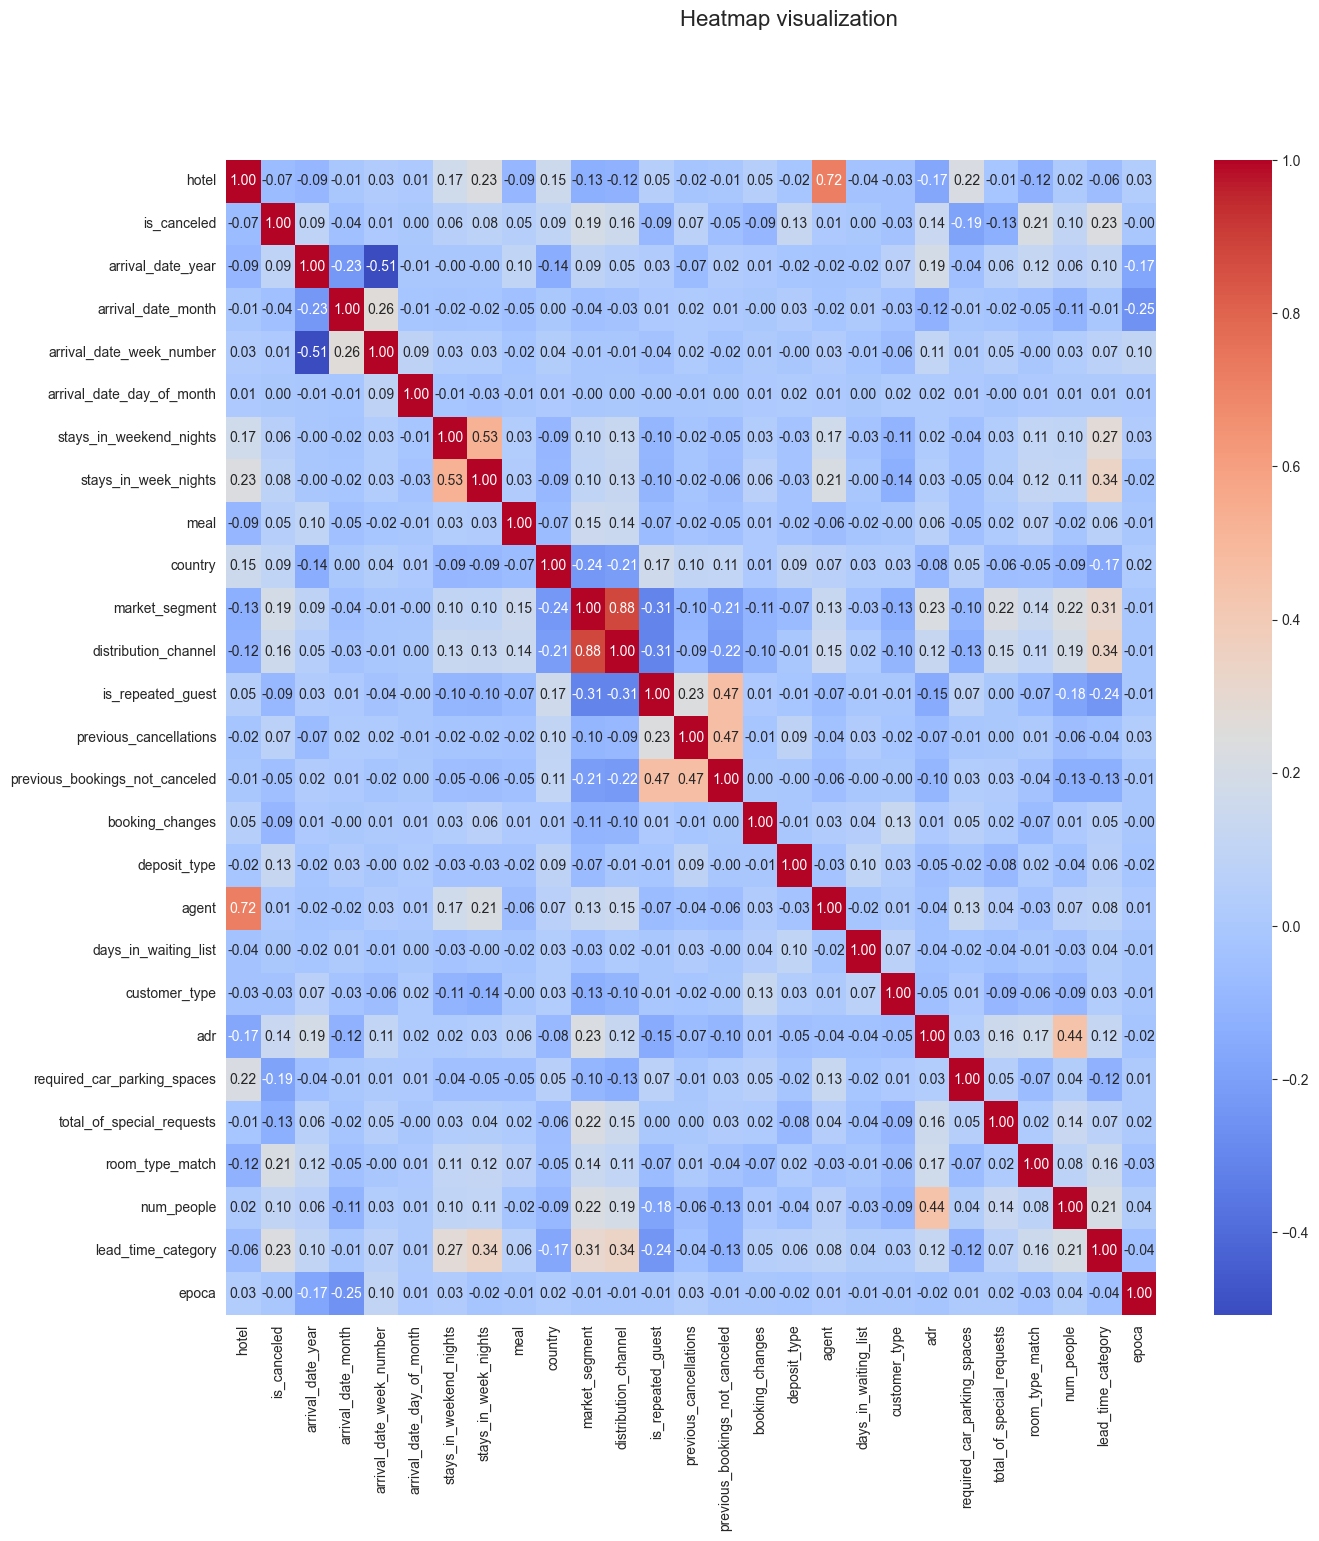

In [33]:
corr_matrix = encoded_data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.suptitle('Heatmap visualization', fontsize=16)
plt.show()

In [ ]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency

    # Creating an empty list of final selected predictors
    SelectedPredictors = []

    for predictor in CategoricalVariablesList:
        CrossTabResult = pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)

        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])

    return (SelectedPredictors)


def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors = []

    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists = inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)

        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])

    return (SelectedPredictors)